In [278]:
import glob
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report

In [279]:
fire_img_list = glob.glob('/kaggle/input/fire-dataset/fire_dataset/fire_images/*.png')
nonfire_img_list = glob.glob('/kaggle/input/fire-dataset/fire_dataset/non_fire_images/*.png')

print('Number of fire images: ',len(fire_img_list))
print('Number of non-fire images: ',len(nonfire_img_list))

Number of fire images:  755
Number of non-fire images:  244


In [280]:
fire_list = []
nonfire_list = []

for i in fire_img_list : 
    fire_list.append([i, True])

for i in nonfire_img_list : 
    nonfire_list.append([i, False])

merged = fire_list + nonfire_list
random.shuffle(merged)

In [281]:
df = pd.DataFrame(merged, columns=['image', 'fire'])
df = df.loc[~(df.loc[:,'image'] == '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.189.png'),:]
df.head()

,image,fire
0,/kaggle/input/fire-dataset/fire_dataset/fire_i...,True
1,/kaggle/input/fire-dataset/fire_dataset/fire_i...,True
2,/kaggle/input/fire-dataset/fire_dataset/fire_i...,True
3,/kaggle/input/fire-dataset/fire_dataset/fire_i...,True
4,/kaggle/input/fire-dataset/fire_dataset/fire_i...,True


In [282]:
df.shape

(998, 2)

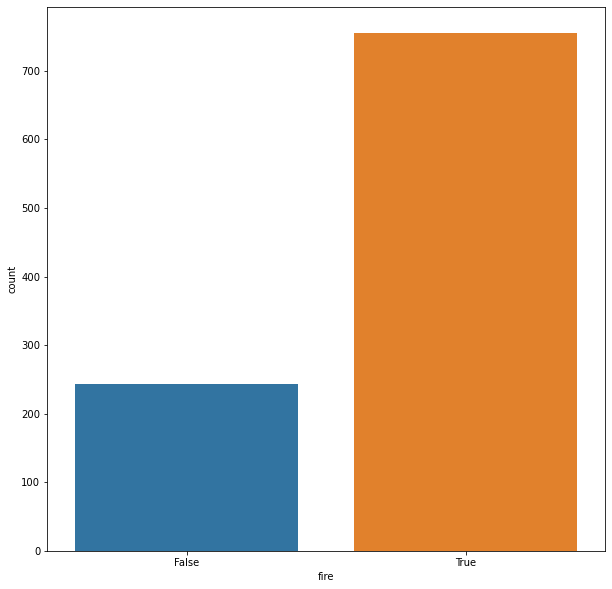

In [283]:
plt.figure(figsize=(10,10))
sns.countplot(x = 'fire', data = df)
plt.show()

In [284]:
def preprocess_image(filepath):
    img = cv2.imread(filepath) #read
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) #convert
    img = cv2.resize(img,(196,196))  # resize
    img = img / 255 #scale
    return img 

In [285]:
def create_format_dataset(dataframe):
    X = []
    y = []
    for f,t in dataframe.values:
        X.append(preprocessing_image(f))
        y.append(t)

    return np.array(X),np.array(y)

In [286]:
X,y = create_format_dataset(df)

In [287]:
X.shape, y.shape

((998, 196, 196, 3), (998,))

In [288]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify = y)

In [289]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((698, 196, 196, 3), (300, 196, 196, 3), (698,), (300,))

In [290]:
model = Sequential()

model.add(Conv2D(128,(3,3),input_shape = (196,196,3),padding='same', activation='relu'))
model.add(Conv2D(128,(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),padding='same', activation='relu'))
model.add(Conv2D(64,(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation= "sigmoid"))
    

In [291]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 196, 196, 128)     3584      
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 196, 196, 128)     147584    
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 98, 98, 128)       0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 98, 98, 128)       0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 98, 98, 64)        73792     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 98, 98, 64)        36928     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 49, 49, 64)      

In [292]:
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 10,restore_best_weights=True)]
model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 30,batch_size = 32,callbacks = callbacks)

Epoch 1/30
22/22 [==============================] - 6s 287ms/step - loss: 0.5218 - accuracy: 0.7479 - val_loss: 0.3015 - val_accuracy: 0.7567
Epoch 2/30
22/22 [==============================] - 6s 270ms/step - loss: 0.3498 - accuracy: 0.7665 - val_loss: 0.3482 - val_accuracy: 0.9300
Epoch 3/30
22/22 [==============================] - 6s 269ms/step - loss: 0.3051 - accuracy: 0.9255 - val_loss: 0.2755 - val_accuracy: 0.9300
Epoch 4/30
22/22 [==============================] - 6s 270ms/step - loss: 0.2716 - accuracy: 0.9484 - val_loss: 0.2455 - val_accuracy: 0.9500
Epoch 5/30
22/22 [==============================] - 6s 266ms/step - loss: 0.2587 - accuracy: 0.9413 - val_loss: 0.2582 - val_accuracy: 0.8967
Epoch 6/30
22/22 [==============================] - 6s 265ms/step - loss: 0.2348 - accuracy: 0.9456 - val_loss: 0.2187 - val_accuracy: 0.9467
Epoch 7/30
22/22 [==============================] - 6s 263ms/step - loss: 0.2208 - accuracy: 0.9527 - val_loss: 0.2292 - val_accuracy: 0.9500
Epoch 

In [293]:
model.save('fire_detector.h5')

In [294]:
y_pred = model.predict(X_test)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1

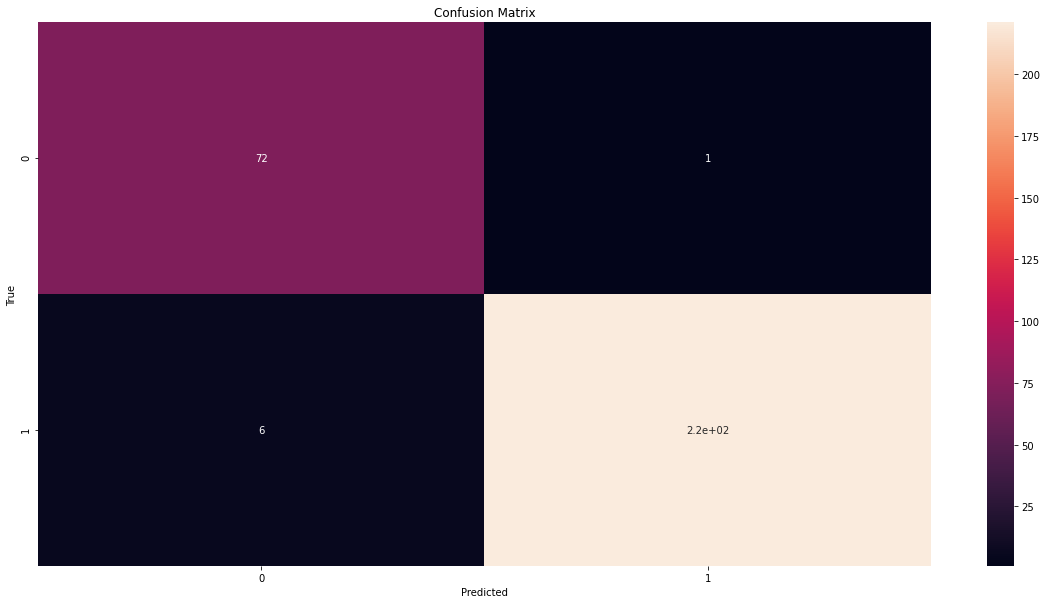

In [295]:
plt.figure(figsize = (20,10))

sns.heatmap(confusion_matrix(y_test,y_pred),annot = True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [296]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.92      0.99      0.95        73
        True       1.00      0.97      0.98       227

    accuracy                           0.98       300
   macro avg       0.96      0.98      0.97       300
weighted avg       0.98      0.98      0.98       300

